# LIGHTCURVE ANALYSIS

We select a subsample of observations from the internal CTAO SDC of the source MRK 421. This is a time-varying source and the aim of this tutorial is to build a lightcurve with the available data.
Let's start with the basic imports:

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion
from gammapy.data import (
    DataStore,
    Observation,
    Observations,
)
from gammapy.datasets import MapDataset, Datasets, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.estimators.utils import get_rebinned_axis
from gammapy.modeling import Fit
from gammapy.makers import (
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.modeling.models import (
    Models,
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    SkyModel,
)

In [2]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

In [3]:
# we need to set the path of the IRF:
#%env CALDB=../caldb/

We select all the observations through the `DataStore` class and we pick only observations enclosed into a search cone of 5 degrees around the given pointing position:

In [4]:
data_store = DataStore.from_dir("../CTA-SDC")

In [5]:
#source coordinates
ra, dec = 166.11380868146 * u.deg, 38.20883291552 * u.deg 
target = SkyCoord(ra, dec, frame="icrs")

#pointing coordinates
pointing = target.directional_offset_by(position_angle = 0 * u.deg, separation = 0.5 * u.deg)

In [6]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pointing.ra.deg,
    lat=pointing.dec.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [7]:
# we select 50 observations:
selected_obs_table = selected_obs_table[0:50]

observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(f"Selected observations: {len(observations)}")
print(f"\n\nLet's have a look at the first observation \n\n: {observations[0]}")

Selected observations: 50


Let's have a look at the first observation 

: Observation

	obs id            : 5000000063 
 	tstart            : 61774.25
	tstop             : 61774.26
	duration          : 445.00 s
	pointing (icrs)   : 166.1 deg, 38.9 deg

	deadtime fraction : 0.0%



Definine the geometry and create the dataset (with eventually the mask):

In [8]:
energy_axis = MapAxis.from_energy_bounds(0.012, 10.0, 8, unit="TeV")

geom = WcsGeom.create(
    skydir=(target.ra.deg , target.dec.deg),
    binsz=0.01,
    width=(3, 3),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 40, 10, unit="TeV", name="energy_true"
)

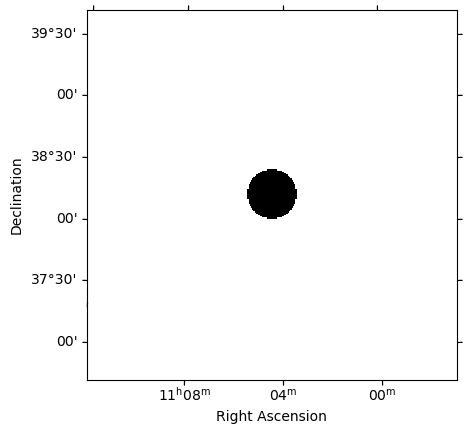

In [9]:
exclusion_geom = geom.to_image()

exclusion_src1 = CircleSkyRegion(
    center=target,
    radius=0.2 * u.deg,
)

exclusion_mask = ~exclusion_geom.region_mask([exclusion_src1])
exclusion_mask.plot()
plt.show()

In [10]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="src"
)

In [11]:
offset_max = 3 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], aeff_percent=10, offset_max=offset_max
)

maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

Finally, we stack all the datasets into a single `dataset` object:

In [12]:
for i, obs in enumerate(observations):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(observations)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 50, Background norm obs 5000000063: 1.12
1 of 50, Background norm obs 5000000064: 1.08
2 of 50, Background norm obs 5000000065: 1.08
3 of 50, Background norm obs 5000000066: 1.10
4 of 50, Background norm obs 5000000130: 1.10
5 of 50, Background norm obs 5000000131: 1.09
6 of 50, Background norm obs 5000000132: 1.08
7 of 50, Background norm obs 5000000133: 1.12
8 of 50, Background norm obs 5000000181: 1.07
9 of 50, Background norm obs 5000000183: 1.06
10 of 50, Background norm obs 5000000184: 1.09
11 of 50, Background norm obs 5000000185: 1.10
12 of 50, Background norm obs 5000000302: 1.08
13 of 50, Background norm obs 5000000303: 1.09
14 of 50, Background norm obs 5000000304: 1.08
15 of 50, Background norm obs 5000000306: 1.07
16 of 50, Background norm obs 5000000503: 1.08
17 of 50, Background norm obs 5000000504: 1.05
18 of 50, Background norm obs 5000000505: 1.06
19 of 50, Background norm obs 5000000506: 1.09
20 of 50, Background norm obs 5000000658: 1.09
21 of 50, Background no

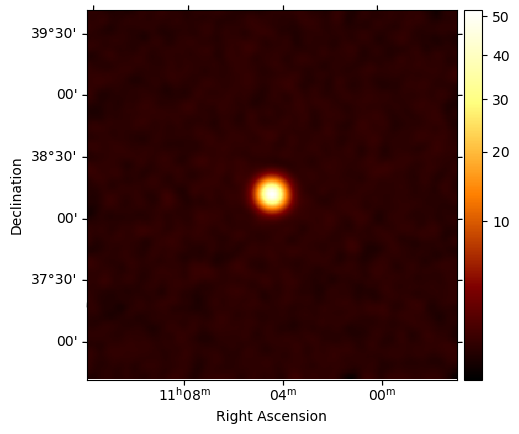

In [13]:
stacked.counts.sum_over_axes().smooth(0.04 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

Let's find out the average spectrum of the source:

In [14]:
spatial_model = PointSpatialModel.from_position(target)

spectral_model = PowerLawSpectralModel(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="MRK_421",
)

# FOR SIMPLICITY, WE ASSUME THE BACKGROUND IS WELL KNOWN AND CAN BE 
# TAKEN FROM THE IRF BKG MODEL:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)
bkg_model.spectral_model.norm.value = 1.0

models_stacked = Models([model, bkg_model])

stacked.models = models_stacked

# For simplicity we might freeze the coordinates:
#stacked.models.parameters["lon_0"].frozen = False
#stacked.models.parameters["lat_0"].frozen = False
stacked.models.parameters["lon_0"].frozen = True
stacked.models.parameters["lat_0"].frozen = True

fit = Fit(store_trace=True)
minuit_opts = {"tol": 0.001, "strategy": 1}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts

result = fit.run(datasets=[stacked])

In [15]:
print(result, stacked.models)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 173
	total stat : 256118.91

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.
 DatasetModels

Component 0: SkyModel

  Name                      : MRK_421
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.322   +/-    0.02             
    amplitude                     :   1.17e-11   +/- 2.6e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    166.114       deg         
    lat_0                 (frozen):     38.209       deg         

Component 1: FoVBackgroundModel

  Name                      : src-bkg
  Datasets names           

# Make a lightcurve

To build a lightcurve, we should firstly define the time bin where the lightcurve has to be estimated:

In [16]:
# define the time intervals
t0 = observations[0].tstart
tstop = observations[-1].tstop
duration = 2 * u.hr
n_time_bins = int( ((tstop-t0)).to("s") / duration) + 10
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]

We can filter all the observations that satisfy the temporal requirements:

In [17]:
short_observations = observations.select_time(time_intervals)

# check that observations have been filtered
print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

Number of observations after time filtering: 52

GTI info:
- Number of GTIs: 1
- Duration: 450.0000002095476 s
- Start: 883894351.174 s MET
- Start: 2028-01-04T06:11:21.990 (time standard: UTC)
- Stop: 883894801.1740001 s MET
- Stop: 2028-01-04T06:18:51.990 (time standard: UTC)



We need to select the events by energy, and we could perform an ON-OFF analysis of the source. In this case, we will adopt the reflected region method:

In [18]:
# Target definition
energy_axis = MapAxis.from_energy_bounds("0.012 TeV", "10 TeV", nbin=10)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.001 TeV", "20 TeV", nbin=20, name="energy_true"
)

on_region_radius = Angle("0.10 deg")
on_region = CircleSkyRegion(center=target, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

In [19]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [20]:
datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

The model used for the data-analisys can obtained from the best-fit above:

In [21]:
spectral_model = PowerLawSpectralModel(
    index=3.322, amplitude=1.17e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="MRK 421")

In [22]:
datasets.models = sky_model

And now, make the lightcurve over the time bins defined above for `MRK 421`, using the Gammapy class `LightCurveEstimator`:

In [23]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.02, 10] * u.TeV,
    source="MRK 421",
    time_intervals=time_intervals,
    selection_optional="all",
)
lc_maker_1d.norm.scan_max = 10

In [24]:
lc_1d = lc_maker_1d.run(datasets)

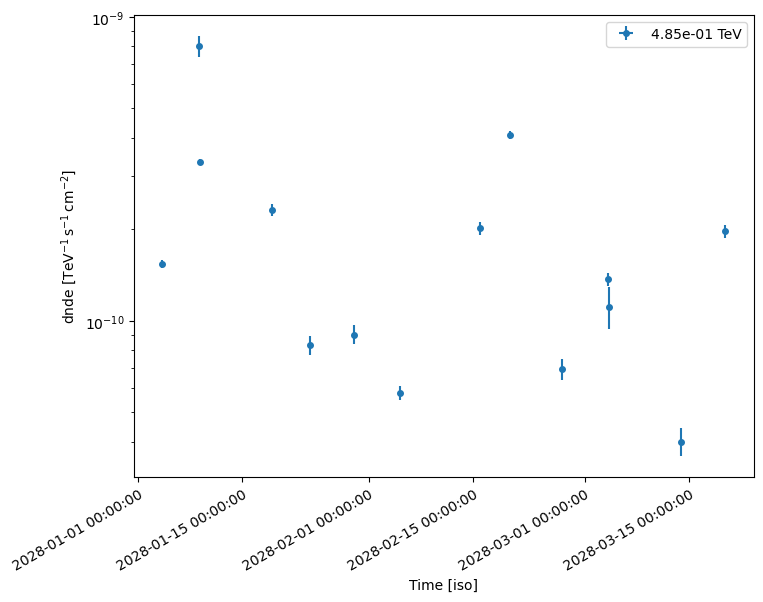

In [25]:
plt.figure(figsize=(8, 6))
lc_1d.plot(marker="o")
plt.show()

<Axes: xlabel='Time [iso]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

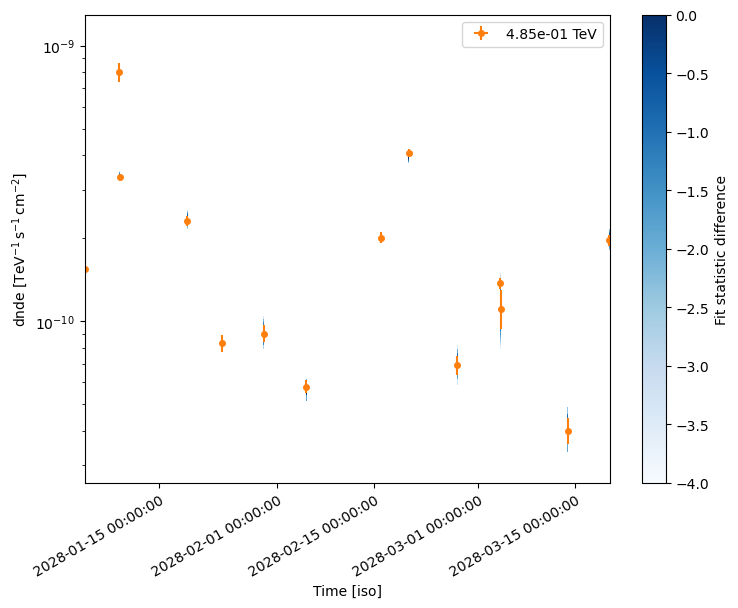

In [26]:
# if we want to inspect the significance of the points:
fig, ax = plt.subplots(
    figsize=(8, 6),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)

lc_1d.plot(ax=ax, color="tab:orange")
lc_1d.plot_ts_profiles()

## Let's consider two energy bands. Is the source spectrally varying?

Perform the same analysis but for two different energy bands. Check if there is a spectral variability during time by making an hardness-ratio of the curves:

In [27]:
lc_maker_1d_new = LightCurveEstimator(
    energy_edges=[0.02, 1, 10] * u.TeV,
    source="MRK 421",
    time_intervals=time_intervals,
    selection_optional="all",
)
lc_maker_1d_new.norm.scan_max = 10
lc_1d_new = lc_maker_1d_new.run(datasets)


In [28]:
ratio = ((lc_1d_new.to_table()["ref_dnde"][:,1] * lc_1d_new.to_table()["norm"][:,1]) / 
         (lc_1d_new.to_table()["ref_dnde"][:,0] * lc_1d_new.to_table()["norm"][:,0] )).data

t = (lc_1d_new.to_table()["time_min"] + lc_1d_new.to_table()["time_max"])/2

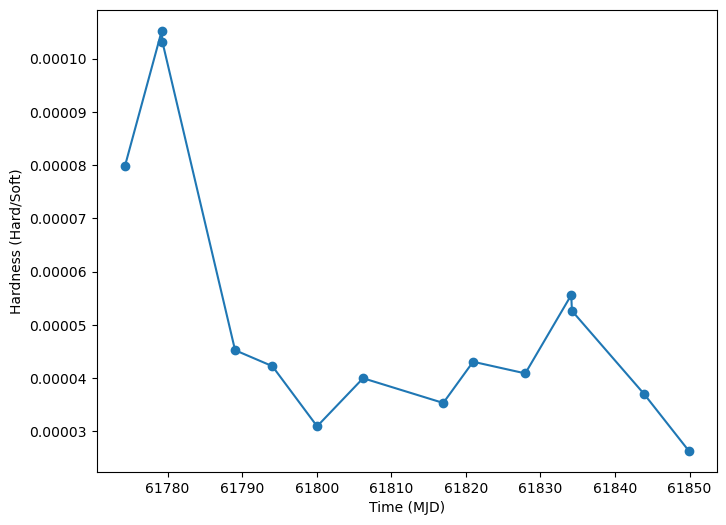

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(t, ratio, marker="o")
plt.ylabel("Hardness (Hard/Soft)")
plt.xlabel("Time (MJD)")
plt.show()

There is a clear spectral variability. To estimate the variability, refer to https://docs.gammapy.org/1.2/tutorials/analysis-time/Variability_estimation.html#sphx-glr-tutorials-analysis-time-variability-estimation-py